<a href="https://colab.research.google.com/github/vectice/vectice-examples/blob/master/Tutorial/Tutorial_Modelling_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

Welcome to the Vectice tutorial notebook!


Through this notebook, we will be illustrating how to log the following information into Vectice using the Vectice Python library:
- Dataset versions
- Model versions
- Runs and lineage

For more information on the tutorial, please refer to the "Vectice Tutorial Page" inside the app.



### Install Vectice and GCS packages

In [ ]:
## Install GCS packages
!pip install --q fsspec
!pip install --q gcsfs

#Install Vectice Python library 
# In this tutorial we will do code versioning using github, we also support gitlab
# and bitbucket: !pip install -q "vectice[github, gitlab, bitbucket]"
!pip install --q vectice[github]==2.2.3


In [ ]:
#Verify if Vectice python library was installed
!pip3 show vectice

## Getting the data from GCS

We are going to load data stored in Google Cloud Storage, that is provided by Vectice for this tutorial.

In [ ]:
# Download the "JSON file" from the "Vectice Tutorial Page" in the application so that 
# you can access the GCS bucket. The name of the JSON file should be "readerKey.json"

from google.colab import files
uploaded = files.upload()

In [13]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Double check the json file name below so that it matches the name of the file that you uploaded.
# Note that the key provided for this tutorial does not have permissions for you to write to GCS. 
# You can only use it to read the data.
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'readerKey.json'

# Once your file is loaded you can view your dataset in a Pandas dataframe.
df = pd.read_csv('gs://vectice_tutorial/kc_house_data_cleaned.csv')

# Run head to make sure the data was loaded properly
df.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Vectice  configuration

In [14]:
#Import the required packages
from vectice import Experiment
from vectice.api.json import ModelType
from vectice.api.json import JobType
from vectice.api.json import JobArtifactType
from vectice.api.json import ModelVersionStatus
from vectice.api.json import VersionStrategy
import logging
import os
logging.basicConfig(level=logging.INFO)

# Specify the API endpoint for Vectice.
# You can specify your API endpoint here in the notebook, but we recommand you to add it to a .env file
os.environ['VECTICE_API_ENDPOINT']= "app.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API token.
# You can generate an API token from the Vectice UI, by going to the "API Tokens" section in the "My Profile" section
# which is located under your profile picture.
# You can specify your API Token here in the notebook, but we recommend you to add it to a .env file
os.environ['VECTICE_API_TOKEN'] = "Your API Token"

# Add you project id. The project id can be found in the project settings page in the Vectice UI
project_id = ID


We will use the scikit-learn library for modeling and tracking experiments directly through the Vectice Python library.

In [15]:
import string
from math import sqrt

# Load scikit-learn packages
from sklearn.model_selection import train_test_split  # Model Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Model Evaluation
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regression

### Split dataset into training and testing

Let's split the dataset into train and test sets and save them in GCS. (The GCS code has been commented out as the data has already been generated). For this section, we will re-use some datasets that have been already created to illustrate dataset versioning.

In [18]:
# We create our first experiment for data preparation and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Data Preparation", project=project_id, job_type=JobType.PREPARATION, auto_code=True)

In [19]:
# The Vectice library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 
# For this tutorial, we changed the data since Albert left the company.
# So, the Vectice Python library will create a new dataset version when this code is executed for the first time.
experiment.add_dataset_version(dataset="cleaned_kc_house_data", version_strategy=VersionStrategy.AUTOMATIC)
# Because we are using Colab in this tutorial example we are going to declare a reference to the code
## manually. This will be added as a reference to the run we are going to create next.
# If you are using your local environment with GIT installed or JupyterLab etc... the code
# tracking is automated.
input_code = experiment.add_code_version_uri(git_uri="https://github.com/vectice/vectice-examples",
                                             entrypoint="Tutorial/Tutorial_Modelling_All.ipynb") 

# The created dataset version and code version will be automatically attached as inputs of the run
experiment.start(run_properties={"Property1": "Value 1", "property2": "Value 2"})

# We will use an 80/20 split to prepare the data
test_size = 0.2

# We will set the random seed so we always generate the same split.
random_state = 42

train, test = train_test_split(df, test_size = test_size, random_state = random_state)

# We commented out the code to persist the training and testing test in GCS, 
# because we already generated the data for you.
# The key provided for this tutorial give you read access only to GCS.
# We left the code below for convenience, in case you want to use your own credentials and GCS bucket.
# train.to_csv (r'gs://vectice_tutorial/training_data.csv', index = False, header = True)
# test.to_csv (r'gs://vectice_tutorial/testing_data.csv', index = False, header = True)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
X = df.drop("price", axis=1).values
y = df["price"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# We create new dataset versions 
train_ds_version = experiment.add_dataset_version(dataset="train_cleaned_kc_house_data", version_strategy=VersionStrategy.AUTOMATIC)
test_ds_version = experiment.add_dataset_version(dataset="test_cleaned_kc_house_data", version_strategy=VersionStrategy.AUTOMATIC)

# We complete the current experiment's run 
## The created dataset versions will be automatically attached as outputs of the run
experiment.complete()
# We can preview one of our generated outputs to make sure that everything was executed properly.
X_train


array([[ 4.00000e+00,  3.00000e+00,  3.61000e+03, ..., -1.22342e+02,
         3.56800e+03,  1.89480e+04],
       [ 3.00000e+00,  2.00000e+00,  2.08000e+03, ..., -1.22285e+02,
         1.92000e+03,  7.00000e+03],
       [ 4.00000e+00,  2.50000e+00,  2.09000e+03, ..., -1.22221e+02,
         1.51000e+03,  7.40200e+03],
       ...,
       [ 3.00000e+00,  1.00000e+00,  1.46000e+03, ..., -1.22191e+02,
         1.15000e+03,  5.92600e+03],
       [ 3.00000e+00,  2.25000e+00,  1.62000e+03, ..., -1.22137e+02,
         1.60000e+03,  7.91000e+03],
       [ 4.00000e+00,  3.50000e+00,  3.38000e+03, ..., -1.22379e+02,
         2.22000e+03,  8.33000e+03]])

## Modeling

In [20]:
# We create our second experiment for modeling and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Modeling", project=project_id, job_type=JobType.TRAINING, auto_code=True)

### Linear regression model

First, we will do a basic Linear Regression and observe the baseline accuracy metrics.

In [21]:
# we declare the dataset versions and code to use as inputs of our run
experiment.start(inputs=[input_code, train_ds_version, test_ds_version],
                run_properties={"Property1": "Value 1", "property2": "Value 2"})

# Linear regression model
lr_rg = LinearRegression()
lr_rg.fit(X_train, y_train)
lr_pred = lr_rg.predict(X_test)

# Evaluate Metrics
MAE = round(mean_absolute_error(lr_pred, y_test),3)
RMSE = round(sqrt(mean_squared_error(lr_pred, y_test)),3)

print("Root Mean Squared Error: ", RMSE)
print("Mean Absolute Error: ", MAE)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
metrics = {"RMSE": RMSE, "MAE": MAE}
model_version = experiment.add_model_version(model="Regressor", algorithm="Linear Regression", metrics=metrics)

# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()

Root Mean Squared Error:  156149.06199382097
Mean Absolute Error:  109761.97924259912


### Decision tree model

In this section let's use the decision tree algorithm and compare the accuracy to the logistic regression algorithm. We will try different values for the tree_depth. We will log the model parameters and metrics in Vectice.

In [ ]:
# We can do a few runs with different max depth for the tree.
# Just change the value below and re-run this cell.
tree_depth = 6

# we declare the code and dataset versions to use as inputs of our run
experiment.start(inputs=[input_code, train_ds_version, test_ds_version],
                run_properties={"Property1": "Value 1", "property2": "Value 2"})

# Decision tree model
dtr = DecisionTreeRegressor(max_depth=tree_depth, min_samples_split=50)
dtr.fit(X_train,y_train)
dtr_pred = dtr.predict(X_test) 

data_feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                      'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
                      'long', 'sqft_living15', 'sqft_lot15']

# Visualize the Decision Tree Model
plt.figure(figsize=(25, 10))
plot_tree(dtr, feature_names=data_feature_names, filled=True, fontsize=10)
attachment_name = "DecisionTree_"+str(tree_depth)+".png"
plt.savefig(attachment_name)

## We can attach the decision tree plot to the model version by using .with_attachments([Attachments])
MAE = round(mean_absolute_error(dtr_pred, y_test),3)
RMSE = round(sqrt(mean_squared_error(dtr_pred, y_test)),3)

print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Error:", MAE)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
metrics = {"RMSE": RMSE, "MAE": MAE}
model_version = experiment.add_model_version(model="Regressor", algorithm="Decision Tree", hyper_parameters={
                            "Tree Depth":tree_depth}, metrics=metrics, attachment=attachment_name)

# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()

### Random forest model

Let's use the Random Forest Regression and do some hyper-parameter tuning on it.

In [ ]:
# You can modify the parameters below and execute multiple runs to train 
## different versions of RF model.
nb_trees = 60
min_samples = 30

# we declare the dataset versions and code to use as inputs of our run
experiment.start(inputs=[input_code, train_ds_version, test_ds_version],
                run_properties={"Property1": "Value 1", "property2": "Value 2"})

rf_regressor = RandomForestRegressor(n_estimators=nb_trees, min_samples_leaf=min_samples)
rf_regressor.fit(X_train, y_train)
rf_regressor.score(X_test, y_test)
rf_regressor_pred = rf_regressor.predict(X_test)

MAE = round(mean_absolute_error(rf_regressor_pred, y_test),3)
RMSE = round(sqrt(mean_squared_error(rf_regressor_pred, y_test)),3)

print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Error:", MAE)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
hyper_parameters = {"nb_trees": nb_trees, "min_samples": min_samples}
metrics = {"RMSE": RMSE, "MAE": MAE}

model_version = experiment.add_model_version(model="Regressor", algorithm="Random Forest", hyper_parameters=hyper_parameters, metrics=metrics)

# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()  

You can also get all the model versions you created in previous runs, for offline analysis and understanding in more details what's driving the models performance.

In [ ]:
experiment.list_model_versions_dataframe(model="Regressor")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,createdDate,name,versionNumber,status,algorithmName,isStarred,RMSE,MAE,nb_trees,min_samples,Tree Depth
0,2022-04-28T08:52:49.234Z,Version 7,7,EXPERIMENTATION,Random Forest,False,124373.49361664786,79187.50617505661,60,60,NaN
1,2022-04-28T08:52:41.638Z,Version 6,6,EXPERIMENTATION,Random Forest,False,115722.88950588116,73254.57657347745,60,30,NaN
2,2022-04-28T08:51:10.534Z,Version 5,5,EXPERIMENTATION,Random Forest,False,115506.33013647195,73068.59985223778,30,30,NaN
3,2022-04-27T07:49:05.155Z,Version 4,4,PRODUCTION,Decision Tree,True,144649.5566489278,95872.63972094451,NaN,NaN,6
4,2022-04-27T07:49:04.155Z,Version 3,3,EXPERIMENTATION,Decision Tree,False,165154.56185163363,112088.19615621041,NaN,NaN,4
5,2022-04-27T07:49:03.155Z,Version 2,2,EXPERIMENTATION,Decision Tree,False,203604.21325245287,141604.0933708193,NaN,NaN,2
6,2022-04-27T07:49:02.155Z,Version 1,1,EXPERIMENTATION,Linear Regression,False,156149.06199382097,109761.97924259912,NaN,NaN,NaN


We can see that the Random Forest Regressor model gives the lowest error and should be the preferred approach despite the complexity of the algorithm. Let's get the list of features' importance to discuss which variables are influencing the model the most.

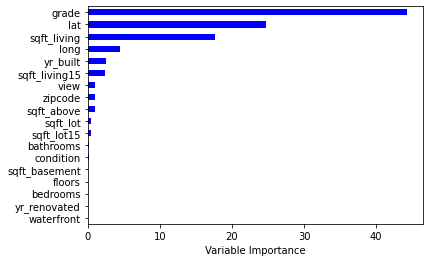

In [ ]:
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
           'waterfront', 'view', 'condition', 'grade', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
           'long', 'sqft_living15', 'sqft_lot15']

importance = pd.DataFrame({'Importance': rf_regressor.feature_importances_ * 100}, index=columns)
importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="b")
plt.xlabel("Variable Importance")
plt.savefig("Variable_Importance.png")

plt.gca().legend_ = None


#Attach the feature_importance to the model
experiment.add_model_version_attachment(file="Variable_Importance.png", model_version="Version 7", model="Regressor")

Thank you and congratulations! You have succesfully completed the notebook part of the tutorial.

In this notebooks we have illustrated how you can capture your experiments, hyper-parameters, dataset versions and metrics using Vectice Python library. 
You can now leverage Vectice UI for analysis, documentation and to engage a business conversation around the findings.

Vectice enables you to:
1. Make your experiments more reproducible.
2. Track the data and code that is used for each experiment and model versions.
3. Document your projects' progress and collaborate with your team in Vectice's UI.
4. Discover previous work and reuse your team knowledge for new projects.

We are constantly improving the Vectice Python library and the Vectice application. Let us know what improvements you would like to see in the solution and what your favorite features are after completing this tutorial. 

Feel free to explore more and come up with your own ideas on how to best start leveraging Vectice!
